# Unstructured Data Analytics HW2

Name: Kanishka Bhambhani

Andrew ID: kbhambha

Collaborators (if none, say "none"; do *not* leave this blank):

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [159]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [160]:
########################################################################
######################### Write your code here #########################
########################################################################
import glob

files = glob.glob('./data/enron/*.txt')

file_data = []
for name in files:  
    data = make_word_list(name)
    file_data.append(data)



### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [161]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf_vectorizer=TfidfVectorizer(min_df=50,stop_words="english",max_df=0.8) 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(file_data)

unique_words = tfidf_vectorizer.vocabulary_
num_of_unique_words = len(unique_words)
print("Unique words : " + str(num_of_unique_words))

Unique words : 1680


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [162]:
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.mixture import GaussianMixture
from collections import Counter

gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(tfidf_vectorizer_vectors.toarray())

labels = gmm.predict(tfidf_vectorizer_vectors.toarray())

num_of_labels = Counter(labels)

print(num_of_labels)

Counter({2: 3023, 1: 1785, 0: 363})


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [163]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

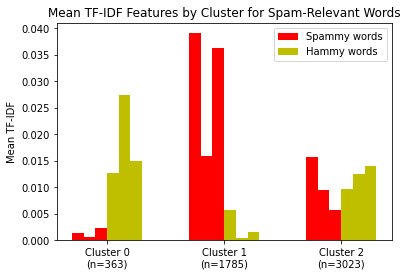

In [175]:
########################################################################
######################### Write your code here #########################
########################################################################

spam_indices = []
ham_indices = []
for index, word in enumerate(unique_words):
    if word == 'click' or word == 'www' or word == 'offer':
        spam_indices.append(unique_words[word])
    if word == 'meeting' or word == 'attached' or word == 'review':
        ham_indices.append(unique_words[word])

plot_spam_words_by_cluster(tfidf_vectorizer_vectors, labels, 3, spam_indices, ham_indices)
    
    

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

*** WRITE YOUR ANSWER HERE IN TEXT ***

3 Clusters -> 
From the plots of the predicted values with 3 clusters we can infer that cluster 1 has a high number of spammy emails, could probably say that the cluster 1 is of spammy emails. Similarly, cluster 0 has a high range of hammy email and can be said that it is a cluster mostly of business emails. But the clusters are not exactly pure. They both have some hammy and spammy emails as well. And cluster 3 has a combination of both, so we cannot deduce much of a conclusion for 3 clusters

After running the matrix and predicting on different number of clusters :

2 Clusters -> The model with 2 clusters does not given any significant knowledge since cluster 0 has a combination of both kind of emails. Even though cluster 1 has more number of spammy emails, the count of business emails is significant as well

5 Clusters -> In this cluster space we can confidently segragate the spam and ham emails in the clusters except for clluster 1 which seems to have a combination of both. This cluster space though performs better than the above mentioned number of clusters. We can notice that the cluster 2 and cluster 3 both have majority of the spam emails. With cluster 2 having just spam emails thus being the spam cluster. The business emails are also well segragated in cluster 0 and cluster 4.

7 clusters -> Even though the segragartion between the spam and ham emails can be seen clearly in few of the clusters. Clusters 2, 3 and 5 being spam clusters, 4 and 6 being ham clusters, there are still 2 clusters with a combination of both of them. 

The conclusion by trying various set of clusters could be that the number of clusters should be between 3 and 7, more optimal from the below clusters can be interpreted as 5, since most of the clusters were distinctly classified between spmammy and hammy. This let's us know that the insights can heavily depend on the number of clusters chosen in order to fit and predict the model.

<Figure size 864x432 with 0 Axes>

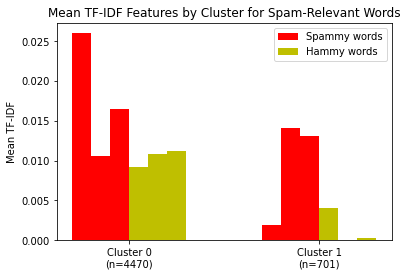

<Figure size 864x432 with 0 Axes>

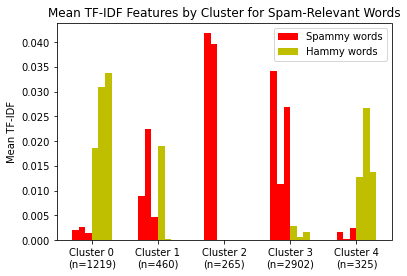

<Figure size 864x432 with 0 Axes>

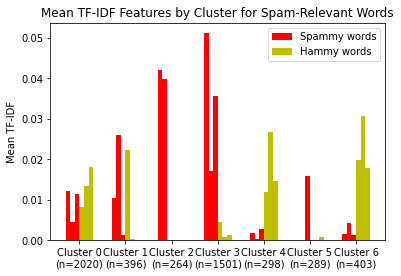

In [176]:
########################################################################
######################### Write your code here #########################
########################################################################

## Re-running the analysis by considering no of clusters as 2:

gmm_2 = GaussianMixture(n_components=2, random_state=0)
gmm_2.fit(tfidf_vectorizer_vectors.toarray())
labels_2=gmm_2.predict(tfidf_vectorizer_vectors.toarray())

plt.figure(figsize=(12,6))
plot_spam_words_by_cluster(tfidf_vectorizer_vectors,labels_2,2,spam_indices,ham_indices)

## Re-running the analysis by considering no of clusters as 5:

gmm_5 = GaussianMixture(n_components=5, random_state=0)
gmm_5.fit(tfidf_vectorizer_vectors.toarray())
labels_5=gmm_5.predict(tfidf_vectorizer_vectors.toarray())
  

plt.figure(figsize=(12,6))
plot_spam_words_by_cluster(tfidf_vectorizer_vectors,labels_5,5,spam_indices,ham_indices)

## Re-running the analysis by considering no of clusters as 7:

gmm_7 = GaussianMixture(n_components=7, random_state=0)
gmm_7.fit(tfidf_vectorizer_vectors.toarray())
labels_7=gmm_7.predict(tfidf_vectorizer_vectors.toarray())
  

plt.figure(figsize=(12,6))
plot_spam_words_by_cluster(tfidf_vectorizer_vectors,labels_7, 7,spam_indices,ham_indices)

## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [166]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [167]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [168]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

### Part C: Downweight "stopwords" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [169]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [170]:
########################################################################
######################### Write your code here #########################
########################################################################
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer() 
stopwords = tfidf_transformer.fit_transform(X).toarray()

In [171]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################

num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, n_jobs=-1, random_state=0, max_iter=10)
lda.fit(stopwords)

Wall time: 1min 25s


LatentDirichletAllocation(n_jobs=-1, random_state=0)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [172]:
########################################################################
######################### Write your code here #########################
########################################################################
alltopics_top_words = []
top_words = np.zeros(len(lda.components_))
for topic_idx, word_dist in enumerate(lda.components_):
    top_word_indices = np.argsort(-word_dist)[:10]
    top_words = [permission_columns[word_idx] + "\n" for word_idx in top_word_indices]
    alltopics_top_words.append(top_words)
    print('Topic', topic_idx, ':\n', ' '.join(top_words))

Topic 0 :
 Your location : coarse (network-based) location (D)
 Your location : fine (GPS) location (D)
 Network communication : full Internet access (D)
 Network communication : view network state (S)
 Phone calls : read phone state and identity (D)
 Storage : modify/delete USB storage contents modify/delete SD card contents (D)
 Services that cost you money : directly call phone numbers (D)
 Your personal information : read sensitive log data (D)
 Network communication : view Wi-Fi state (S)
 Default : access checkin properties (S)

Topic 1 :
 Hardware controls : control vibrator (S)
 Network communication : full Internet access (D)
 Network communication : view network state (S)
 Storage : modify/delete USB storage contents modify/delete SD card contents (D)
 System tools : disable keylock (D)
 Phone calls : read phone state and identity (D)
 System tools : prevent device from sleeping (D)
 Hardware controls : change your audio settings (D)
 Default : modify battery statistics (S)
 

*** WRITE YOUR ANSWER HERE IN TEXT ***

Following are the interpretations for various topics:

Topic #0 : Has GPS permissions and combined with Internet permissions can indicate applications with the Map feature. 

Topic #1 : The topic has permission related to vibration and preventing the app from goind to sleep. Also battery and network related permissions. It could be have applications related to video streaming online or gaming.

Topic 2# : It has permissions regaring Google Finance and user authentication, it could be related to the banking applications, since they require the user to authenticate

Topic 5# : Reading, writing instant permissions and taking pictures and videos indicate the applications can be related to the Social Media domain, for example Facebook or Instagram.

Topic 7# : The permissions are related to Wi-FI, network and bluetooth connectivity hinting towards the Networking applications

Topic 9# : The premissions revolve around reading and writing sms and reading contact data. The applications could be related to calling and messaging. Example: SMS and Phone contacts


### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [173]:
########################################################################
######################### Write your code here #########################
########################################################################

top_ratings = app_ratings>100000

topic_matrix = lda.transform(stopwords)

app_names_array=np.array(app_names)

for topic_index in range (len(lda.components_)):
    print('Topic ', topic_index, ' :', sep='')
    app_index_values=np.argsort(-topic_matrix[top_ratings][:,topic_index])[:3]
    for app_index in app_index_values:
        print(app_names_array[top_ratings][app_index], " : ",topic_matrix[top_ratings][app_index,topic_index])


Topic 0 :
Dictionary.com  :  0.7169213652901968
Air Control Lite  :  0.7169213652901968
Paper Toss  :  0.693537007927831
Topic 1 :
Vaulty Free Hides Pictures  :  0.7166941882853555
Live Holdem Poker Pro  :  0.7166941882853555
Bubble Blast 2  :  0.6932433156888418
Topic 2 :
Angry Birds Seasons  :  0.6247326164893362
Yoo Ninja! Free  :  0.6247326164893362
Adobe Reader  :  0.5499688253454359
Topic 3 :
Lookout Security & Antivirus  :  0.8569142310189861
Antivirus Free  :  0.8544435285083867
Skype  :  0.8488560887483078
Topic 4 :
Real BlackJack  :  0.7163547288042715
Alchemy  :  0.7154575322062603
Tank Hero  :  0.7153329576328672
Topic 5 :
World Newspapers  :  0.6962050155184168
Paradise Island  :  0.6962050155184168
My Country  :  0.6962050155184168
Topic 6 :
Brightest Flashlight Free™  :  0.7624645101661686
Brightest Flashlight Free???  :  0.7624645101661686
Tiny Flashlight + LED  :  0.7496671670476458
Topic 7 :
Slice It!  :  0.7208866952958151
Racing Moto  :  0.6877805097076612
Blast Mon

### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

C:\Users\kanis\Miniconda3\envs\uda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\kanis\Miniconda3\envs\uda\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


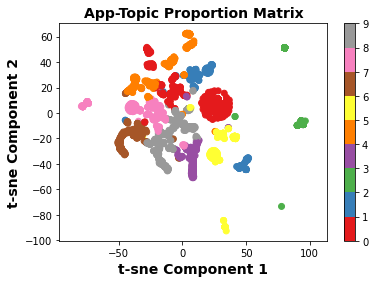

Wall time: 13 s


In [178]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.manifold import TSNE

tsne = TSNE(init='pca', angle = 0.99, n_components=2, random_state=0)
X_tsne2D = tsne.fit_transform(topic_matrix[0:2500])

topic_list =[]
for topic in topic_matrix[0:2500]:
    topic_list.append(np.argmax(topic))

plt.scatter(X_tsne2D[:, 0],
            X_tsne2D[:, 1],
            c=topic_list, cmap='Set1')

plt.axis('equal')
plt.title('App-Topic Proportion Matrix',fontweight ='bold', fontsize = 14)
plt.xlabel('t-sne Component 1',fontweight ='bold', fontsize = 14)
plt.ylabel('t-sne Component 2',fontweight ='bold', fontsize = 14)
plt.colorbar()
plt.show()



## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://forms.gle/vquMWbW9bbTedCJd7